# Assignment 2 in System Genetics - Gil Sasson & Tomer Schweid

## Loading Modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_selection import f_regression
from scipy.stats import f_oneway
from statsmodels.stats import multitest
pd.options.mode.copy_on_write = True # A setting in pandas that suppresses warning in one of the operations so the notebook is cleaner

## Data Preparation
First let's load the data from the phenotypes and genotypes files

In [2]:
directory_path = '.' # Path to alphabet's directory, assuming it is in the working directory and that both files are in the same location
phenotypes = pd.read_csv(directory_path + "/phenotypes.txt")
genotypes = pd.read_csv(directory_path + "/genotypes.txt")

Let's take a look at the files:

In [3]:
print(phenotypes.head().to_string())

   ID_FOR_CHECK                                                                                                                   Phenotype                      Authors  Year   Pubmed Id  C57BL/6J  DBA/2J   BXD1   BXD2   BXD5   BXD6   BXD8   BXD9  BXD11  BXD12  BXD13  BXD14  BXD15  BXD16  BXD18  BXD19  BXD20  BXD21  BXD22  BXD23  BXD24  BXD25  BXD27  BXD28  BXD29  BXD30  BXD31  BXD32  BXD33  BXD34  BXD35  BXD36  BXD37  BXD38  BXD39  BXD40  BXD41  BXD42  BXD43  BXD44  BXD45  BXD48  BXD49  BXD50  BXD51  BXD52  BXD53  BXD54  BXD55  BXD56  BXD59  BXD60  BXD61  BXD62  BXD63  BXD64  BXD65  BXD66  BXD67  BXD68  BXD69  BXD70  BXD71  BXD72  BXD73  BXD74  BXD75  BXD76  BXD77  BXD78  BXD79  BXD80  BXD81  BXD83  BXD84  BXD85  BXD86  BXD87  BXD88  BXD89  BXD90  BXD91  BXD92  BXD93  BXD94  BXD95  BXD96  BXD97  BXD98  BXD99  BXD100  BXD101  BXD102  BXD103
0             0                                                                                                      Cerebellum weight [mg]  Airey 

In [4]:
print(genotypes.head().to_string()) # B = 0, H = 1, D = 2, U = Unknown

   0      Locus  Chr_Build37  Build37_position  BXD1  BXD2  BXD5  BXD6  BXD8  BXD9  BXD11  BXD12  BXD13  BXD14  BXD15  BXD16  BXD18  BXD19  BXD20  BXD21  BXD22  BXD23  BXD24  BXD25  BXD27  BXD28  BXD29  BXD30  BXD31  BXD32  BXD33  BXD34  BXD35  BXD36  BXD37  BXD38  BXD39  BXD40  BXD41  BXD42  BXD43  BXD44  BXD45  BXD48  BXD49  BXD50  BXD51  BXD52  BXD53  BXD54  BXD55  BXD56  BXD59  BXD60  BXD61  BXD62  BXD63  BXD64  BXD65  BXD66  BXD67  BXD68  BXD69  BXD70  BXD71  BXD72  BXD73  BXD74  BXD75  BXD76  BXD77  BXD78  BXD79  BXD80  BXD81  BXD83  BXD84  BXD85  BXD86  BXD87  BXD88  BXD89  BXD90  BXD91  BXD92  BXD93  BXD94  BXD95  BXD96  BXD97  BXD98  BXD99  BXD100 BXD101 BXD102 BXD103
0  1  rs6269442            1           3482276     0     0     2     2     2     0      0      2      0      0      2      2      0      2      2      2      2      0      0      2      0      2      2      0      0      0      0      0      0      0      0      0      2      0      2      0      0      2      0 

There are two things that needs to be fixed.
1. Some strains in the genotypes file are have an unknown genotype
2. Some data is presented as NaN in the phenotypes file

To fix this we will first remove strains with unknown alleles from both dataframes. Then we will take only the relevant data for analysis from both dataframes to a combined dataframe (named data). For the combined dataframe we will take only our chosen phenotype (Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death], phenotype_id = 787). We will fix the NaN values later on.

In [5]:
# Dropping strains with unknown alleles
strains_with_unknown_genotype = genotypes.columns[genotypes.isin(['U']).any()]
genotypes = genotypes.drop(strains_with_unknown_genotype, axis=1) 
phenotypes = phenotypes.drop(strains_with_unknown_genotype, axis=1)
print(f'The following mice strains were removed due to one or more unknown genotype:\n {list(strains_with_unknown_genotype)}')

# Selecting our phenotype
phenotype_id = 787 # The chosen phenotype ID
phenotype = phenotypes.iloc[phenotype_id, 7:]

# Creating a dataframe for analysis
data = pd.concat([genotypes, phenotype.to_frame().T]).T

The following mice strains were removed due to one or more unknown genotype:
 ['BXD101', 'BXD102', 'BXD103']


## Question 1
First, Let's choose a specific SNP to analyze. We will just take one randomly and create a dataframe that contains only it and the phenotype (data_one_snp). We will then take only relevant data from it (Chromosome, Locus and more are unnecessary for this question).

In [6]:
# Choosing SNP
np.random.seed(77)
snp_idx = np.random.choice(genotypes.index.values)
chosen_snp = genotypes.loc[snp_idx, 'Locus']
print(f"Chosen SNP is: {chosen_snp}")
print(f"Are there heterozygotes strains?: {genotypes.loc[snp_idx].isin([1]).any().any()}")

# Create a alphabet frame only with the chosen SNP and phenotype
data_one_snp = data.copy()
data_one_snp = data_one_snp.iloc[:, [snp_idx, -1]]
data_one_snp.rename({snp_idx:'Genotype', phenotype_id: 'Phenotype'}, axis=1, inplace=True)

# Change alphabet type to numeric for analysis
data_one_snp = data_one_snp.apply(pd.to_numeric, errors='coerce')

# Getting rid of NaN values
data_one_snp = data_one_snp.dropna(axis=0, how='any')

# Check the number of rows before removing hetrozygotes
print(f'There are {data_one_snp.shape[0]} valid mice strains for this phenotype')

Chosen SNP is: rs3655295
Are there heterozygotes strains?: True
There are 66 valid mice strains for this phenotype


Great, now let's run a regression for this SNP. We will do it both without (section A) and with (Section B) hetrozygotes data
### Section A
We are going to run a simple (single variable) linear regression (only on homozygous strains).
Simple linear regression has the following assumptions:
1. Independence: The residuals are independent of each other.
2. Linearity: The relationship between the independent variable and the dependent variable is linear.
3. Homoscedasticity: The residuals have constant variance at all levels of the independent variable.
4. Normality: The residuals are normally distributed.

In [7]:
# Remove heterozygotes
heterozygote_strains = data_one_snp[data_one_snp.iloc[:, 0] == 1].index
data_one_snp_no_heterozygotes = data_one_snp.copy()
data_one_snp_no_heterozygotes.drop(heterozygote_strains, inplace=True)

# Check the number of rows after removing hetrozygotes
print(f'There are {data_one_snp_no_heterozygotes.shape[0]} valid (only homozygotes) mice strains for this phenotype')

# Perform linear regression without heterozygtes alphabet
x = data_one_snp_no_heterozygotes.iloc[:,0]
x = x.values.reshape(-1,1)
y = data_one_snp_no_heterozygotes.iloc[:,1]
f_statistic, p_value = f_regression(x, y)

# Print results
print('\nLinear regression results:')
print(f"F statistic:\t{f_statistic[0]}")
print(f"p value:\t{p_value[0]}")

# Save p value for comparison in question 2 section A 
q1a_p_value = p_value[0]

There are 65 valid (only homozygotes) mice strains for this phenotype

Linear regression results:
F statistic:	0.4042591115706324
p value:	0.5272008572366709


### Section B
In this section we are going to run simple linear regression that includes all strains (homozygous and heterozygous). You can see simple linear regression assumptions in section A above.

In [8]:
# Perform linear regression with heterozygzztes alphabet
x = data_one_snp['Genotype']
x = x.values.reshape(-1, 1)
y = data_one_snp['Phenotype']
f_statistic, p_value = f_regression(x, y)

# Print results
print('\nLinear regression results:')
print(f"F statistic:\t{f_statistic[0]}")
print(f"p value:\t{p_value[0]}")


Linear regression results:
F statistic:	0.3883369913103098
p value:	0.5353893397807714


### Section C
In this section we are going to run ANOVA (ANalysis Of VAriance) on homozygous strains. ANOVA test has the following assumptions:
1. Independence: The observations within each group and between groups are independent of each other.
2. Normality: The residuals within each group should be approximately normally distributed.
3. Homogeneity of variances: The variances of the residuals are equal across the different groups.

In [9]:
# Splitting the strains to two groups (B and D strains)
b_homozygotes_strains = data_one_snp[data_one_snp['Genotype'] == 0]
d_homozygotes_strains = data_one_snp[data_one_snp['Genotype'] == 2]

# Perform the ANOVA
f_statistic, p_value = f_oneway(b_homozygotes_strains['Phenotype'], d_homozygotes_strains['Phenotype'])

# Print results
print('ANOVA results:')
print(f"F statistic:\t{f_statistic}")
print(f"p value:\t{p_value}")

ANOVA results:
F statistic:	0.404259111570637
p value:	0.5272008572366672


We observed that the linear regression model without heterozygous strains and the ANOVA model yielded the same p-values (up to the 15th decimal place, the difference could be attributed to implementation in different libraries). This is expected since one-way ANOVA is a special case of linear regression when the independent variable is categorical.

The p-value for the linear regression model including heterozygous strains was slightly higher. This indicates a reduction in the statistical significance of the genotype effect when the heterozygous strain is considered. This is likely due to the mitigation of differences between genotype groups. However, since we only had data for one heterozygous strain for this phenotype, the small sample size is likely a contributing factor to this effect. The limited data from the heterozygous strain reduces the model's ability to detect significant differences and adds variability, impacting the overall results. Therefore, interpretation of this effect should be taken with a grain of salt, and additional data from heterozygous strains would be beneficial for a more robust analysis.


## Question 2
### Section A
Now we will run regression for all SNPs (without heterozygotes data)

In [10]:
# Preparing alphabet for analysis
data_all_snp = data.iloc[4:] # Removing irrelevant rows (Chromosome, Position, etc.)
data_all_snp = data_all_snp.apply(pd.to_numeric, errors='coerce')

# Set columns names to SNPs names
data_all_snp.columns = data.iloc[1]
data_all_snp.columns.name = None
data_all_snp.dropna(inplace=True) # Drop NaNs

# Extracting phenotype and genotypes
phenotype = data_all_snp.iloc[:,-1]
genotypes_all = data_all_snp.iloc[:,:-1]

We will separate SNPs that are only homozygous from those that contain at least one heterozygous strain.
Those which contain heterozygous strain are delt with in the for loop where we take into account only homozygotes data from them.

In [11]:
# Find the SNPs that has at least one strain which is heterozygous
heterozygotes_snps = genotypes_all.columns[genotypes_all.isin([1]).any()]
heterozygotes_df = genotypes_all[heterozygotes_snps]

# Find the SNPs that has only homozygotes
homozygotes_snps = genotypes_all.columns.difference(heterozygotes_snps)
homozygotes_df = genotypes_all[homozygotes_snps]

# Run model on all homozygotes only SNPs
f_statistics_homozygotes, p_values_homozygotes = f_regression(homozygotes_df, phenotype)

# Run model on every SNP that has at least one heterozygous strain
p_values_heterozygotes = []
for snp in heterozygotes_df:
    homozygous_strains_indices = heterozygotes_df.index[heterozygotes_df.loc[:, snp] != 1] # Finding indices for homozygotes strains for this SNP
    x = heterozygotes_df.loc[homozygous_strains_indices, [snp]]
    y = phenotype.loc[homozygous_strains_indices]
    f_statistic, p_value = f_regression(x, y)
    p_values_heterozygotes.append(p_value[0]) # Add p_value to the list

# Combine lists
snps = list(homozygotes_df.columns) + list(heterozygotes_df.columns)
Ps = list(p_values_homozygotes) + list(p_values_heterozygotes)

# Create a table of SNPs and -log(p) in descending order
pval_data = pd.DataFrame({'SNP': snps, '-log P-value': -np.log10(Ps)})
pval_data.sort_values(by='-log P-value', ascending=False, inplace=True, ignore_index=True)

# Save the alphabet to a new text file
output_file_name = "log_p_values_data"
output_file_path = f"{directory_path}/{output_file_name}.txt"
pval_data.to_csv(output_file_path, sep=',', index=False)
print(f'Output file with the results was saved to {output_file_path}')

Output file with the results was saved to ./log_p_values_data.txt


Here are the top SNPs and their corresponding -log(p values):

In [12]:
print(pval_data.head(10).to_string())

              SNP  -log P-value
0       rs6324652      4.581065
1       rs6323034      4.581065
2  CEL-2_39972578      4.070538
3       rs4136879      4.070538
4      rs13476452      4.070538
5  CEL-2_40063411      4.070538
6       rs3656948      4.051593
7       rs6278585      4.039169
8       rs3717212      4.039169
9      rs13483110      4.013516


We should validate that our code in this question yields the same results as section A in question 1:

In [13]:
q2a_p_value = 10 ** (-pval_data[pval_data.SNP == chosen_snp]['-log P-value'].values)[0] # Converting -log(p) into p value
print(f'Did we get the same p value as in section A in question 1? {q1a_p_value == q2a_p_value}') # Comparing p values

Did we get the same p value as in section A in question 1? True


### Section B
Let's create a Manhattan plot =)

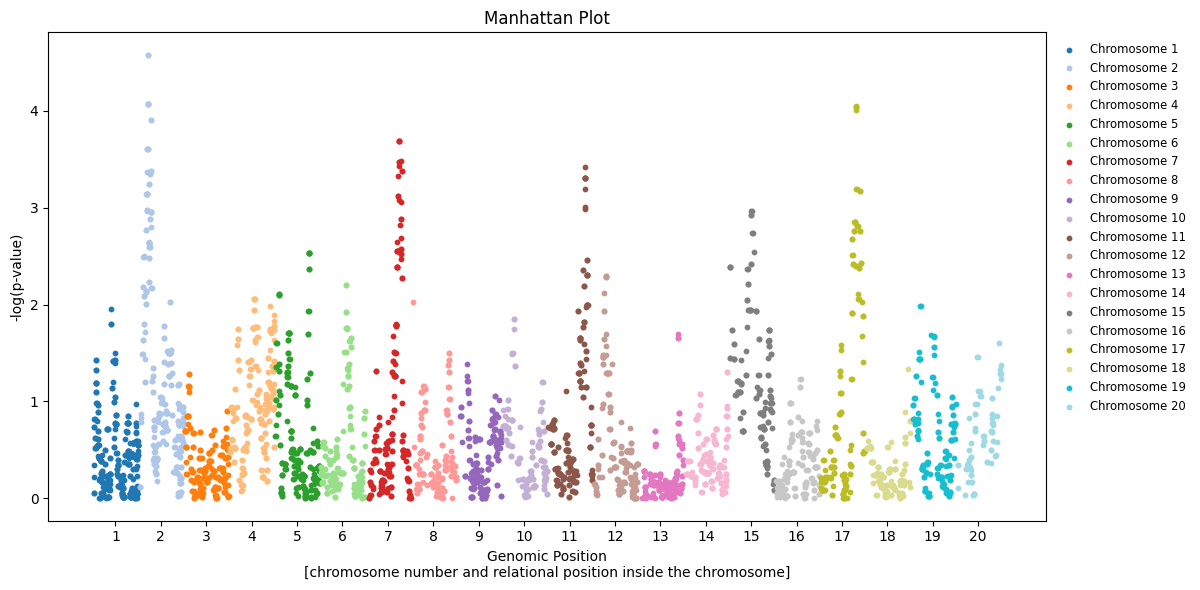

In [14]:
# Gathering relevant alphabet for the Manhattan plot
plot_data = data.T.merge(pval_data, left_on='Locus', right_on='SNP', how='inner') # Adding -log(p) values
plot_data = plot_data[['Chr_Build37', 'Build37_position', '-log P-value']] # Selecting only relevant columns
plot_data = plot_data.rename(columns={'Chr_Build37': 'Chromosome', 'Build37_position': 'Position', '-log P-value': '-log(p)'}) # Changing columns names
plot_data = plot_data.astype({'Chromosome':'int'}) # Setting chromosome to type integer
chromosome_colors = plt.cm.tab20(np.linspace(0, 1, 20)) # Define colors for chromosomes

# Plotting the Manhattan plot
plt.figure(figsize=(12, 6))
for chromosome in plot_data['Chromosome'].unique():
    chromosome_data = plot_data[plot_data['Chromosome'] == chromosome] # Taking only this chromosome alphabet
    chromosome_length_approximation = chromosome_data['Position'].max() # The maximal base pair reference
    chromosome_data['Normalized Position'] = chromosome - 0.5 + (chromosome_data['Position'] / chromosome_length_approximation) # Adjusting plot position such that each SNP dot is presented on the right chromosome and with the relational position on the chromosome itself, each chromosome alphabet is around that chromosome number in the plot
    plt.scatter(chromosome_data['Normalized Position'], chromosome_data['-log(p)'], 
        color=chromosome_colors[chromosome-1], s=10, label=f'Chromosome {chromosome}' if chromosome <= len(chromosome_colors) else "") # Plotting the dots

# Customize the plot
plt.title('Manhattan Plot')
plt.xlabel('Genomic Position\n[chromosome number and relational position inside the chromosome]')
plt.ylabel('-log(p-value)')
plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1), fontsize='small', ncol=1, frameon=False)
plt.tight_layout()
plt.xticks(list(range(1, 21)))
plt.show()

We are asked to report the best scored SNP and discuss its statistical significance. The best scored SNP is:

In [15]:
print(pval_data.head(3).to_string())

              SNP  -log P-value
0       rs6324652      4.581065
1       rs6323034      4.581065
2  CEL-2_39972578      4.070538


So we have **two best scored SNPs**, and they are **rs6324652** and **rs6323034** with the same -log(p) values.

To discuss the statistical significance of those SNPs properly we will run multiple tests correction (Benjamini-Hochberg). We chose Benjamini-Hochberg to give us more power but also to control FDR at level α (5%).

We will create a new dataframe for it (comparison_data) which will also serve us in section C.

In [16]:
# Creating a dataframe with the relevant information
comparison_data = plot_data.copy() # Copying relevant alphabet
comparison_data['p'] = 10 ** (-comparison_data['-log(p)']) # Converting -log(p) into p value
comparison_data['is_significant?'], comparison_data['corrected_p'], _, _ = multitest.multipletests(comparison_data['p'], method='fdr_bh') # Preform Benjamini-Hochberg correction on p values

# Showing our two SNPs 
print(comparison_data.sort_values('-log(p)', ascending=False, ignore_index=True).head(2).to_string())

   Chromosome    Position   -log(p)         p  is_significant?  corrected_p
0           2  40655059.0  4.581065  0.000026             True     0.036797
1           2  40196435.0  4.581065  0.000026             True     0.036797


We can see that both of those SNPs (same -log(p) as we saw in pval_data dataframe) are statistically significant after multiple test correction. Therefore, we can claim that those SNPs are correlated with our phenotype (Infectious disease, immune function: H5N1 influenza A virus mortality rate 30 days after infection (Boon-Webby Trait 1) [% death]) and since they are in different loci it is probable that a DNA variance between them is related to our chosen phenotype. Please note that it could also be that the DNA variance is upstream or downstream to both of the SNPs.

### Section C
The compared article ([Adrianus C. M. Boon et. al, 2009](https://doi.org/10.1128/jvi.00514-09)) is using Megabase pair so we will convert our position to match theirs

In [17]:
# Editing dataframe. Adding column and sort by statistical significance
comparison_data['Mbp position'] = (comparison_data['Position']) / 1000000 # Converting base pair position into megabase position
comparison_data.sort_values(by='corrected_p', inplace=True, ignore_index=True) # Sorting according to corrected p value

# Switching columns so that position columns and statistics columns are together
columns = list(comparison_data.columns)
columns[2], columns[3] = columns[3], columns[2]  
comparison_data = comparison_data[columns]

The researchers has found 5 significant loci on chromosomes 2 (33-52 Mbp), 7 (100-114 Mbp), 11 (101-107 Mbp), 15 (51-57 Mbp) and 17 (68-84 Mbp).
Let's see what we found on those chromosomes:



In [18]:
researchers_chromosomes = [2, 7, 11, 15, 17]
for chromosome in researchers_chromosomes:
    chromosome_data = comparison_data[comparison_data['Chromosome'] == chromosome] # Filtering for current chromosome
    chromosome_data.sort_values(by='corrected_p', inplace=True, ignore_index=True) # Ordering rows according to corrected p value
    chromosome_data = chromosome_data[['Chromosome', 'Mbp position', 'is_significant?', 'corrected_p', 'p']] # Selecting only relevant columns
    print(chromosome_data.head().to_string()) # Printing current chromosome information

   Chromosome Mbp position  is_significant?  corrected_p         p
0           2     39.95894             True     0.036797  0.000085
1           2    40.196435             True     0.036797  0.000026
2           2    40.655059             True     0.036797  0.000026
3           2     40.78349             True     0.036797  0.000085
4           2    41.295574             True     0.036797  0.000085
   Chromosome Mbp position  is_significant?  corrected_p         p
0           7   114.746367             True     0.049098  0.000204
1           7   114.542346             True     0.049098  0.000204
2           7   114.512549             True     0.049098  0.000204
3           7   111.297536            False     0.052071  0.000469
4           7   122.338369            False     0.052071  0.000422
   Chromosome Mbp position  is_significant?  corrected_p         p
0          11   101.318783            False     0.052071  0.000382
1          11   101.460336            False     0.052071  0.00

We can see that we indeed got a significant results for chromosomes 2, 7 and 17 at around the same loci. Although our results for chromosomes 11 and 15 are insignificant we can see that they are almost significant (with corrected p values of 0.052071 and 0.067479 for chromosomes 11 and 15 respectively) and the loci match those reported in the article.
We have multiple reasons for the differences between our results and the researchers results:

1. Although the researchers declared chromosomes 11 and 15 as related to the **disease**, in their Manhattan plot (Figure 2C) they say that only chromosomes 2, 7 and 17 had a LOD higher than 3.8 which is the significance threshold (Figure 2C is about our phenotype - mortality).
2. In their article the researchers applied multiple methods for their research and examined two phenotypes (our phenotype of mortality and another one of survival). The QTL analysis for the mortality matches our findings. Chromosomes 11 and 15 were found via linkage analysis and are relevant to the second phenotype (survival).

Note: The researchers used a permutation test to find the genes and we used linear regression.

Just to check, let's see if we found something that the researchers did not find:

In [19]:
significant_snps = comparison_data[comparison_data['is_significant?']] # Taking only significant results
significant_snps[~significant_snps['Chromosome'].isin(researchers_chromosomes)] # Checking for significant results in chromosomes that were not reported by the researchers

,Chromosome,Position,p,-log(p),is_significant?,corrected_p,Mbp position


So we did not find results in an unreported chromosome. We can see from the table above (the one that contains information and not the empty one) that for chromosome 7 and 17 the significant results match the reported loci. But the table presents only the top 5 SNPs and chromosome 2 has 5 significant results (or more). Let's check if chromosome 2 has more than 5 significant SNPs, and if so, let's check if we found a significant result in chromosome 2 in an unreported locus:

In [20]:
comparison_data[((comparison_data['Chromosome'] == 2) & (comparison_data['is_significant?']))].sort_values(by='Mbp position', ignore_index=True) # Taking only siginificant results in chromosomes 2, ordered by position

,Chromosome,Position,p,-log(p),is_significant?,corrected_p,Mbp position
0,2,35957196.0,0.000246,3.609513,True,0.049098,35.957196
1,2,37285190.0,0.000246,3.609513,True,0.049098,37.28519
2,2,37512633.0,0.000246,3.609513,True,0.049098,37.512633
3,2,39670020.0,0.000246,3.609513,True,0.049098,39.67002
4,2,39868107.0,0.000085,4.070538,True,0.036797,39.868107
5,2,39958940.0,0.000085,4.070538,True,0.036797,39.95894
6,2,40196435.0,0.000026,4.581065,True,0.036797,40.196435
7,2,40655059.0,0.000026,4.581065,True,0.036797,40.655059
8,2,40783490.0,0.000085,4.070538,True,0.036797,40.78349
9,2,41295574.0,0.000085,4.070538,True,0.036797,41.295574


We can see that all the significant SNPs we found match the reported loci in the article (33-52 Mbp)